# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set options for displaying dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# 2. Load data & Basic information

In [3]:
bureau = load_data('dseb63_bureau.csv',
                   verbose=3,
                   filename_train='dseb63_application_train.csv')

Table: dseb63_bureau.csv
Shape: (1465325, 17)

Number of categorical variables: 3
Number of numerical variables: 14

Number of unique values of SK_ID_CURR: 263491

Number of duplicate values: 0

Shape of train set: (246009, 123)
Number of overlapping SK_ID_CURR in dseb63_bureau.csv and dseb63_application_train.csv: 210809


,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET
0,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,91323.00,0.00,NaN,0.00,Consumer credit,-131,NaN,254629,0.00
1,5714463,Active,currency 1,-208,0,1075.00,NaN,NaN,0,225000.00,171342.00,NaN,0.00,Credit card,-20,NaN,254629,0.00
2,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,464323.50,NaN,NaN,0.00,Consumer credit,-16,NaN,254629,0.00
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.00,Credit card,-16,NaN,254629,0.00
4,5714466,Active,currency 1,-629,0,1197.00,NaN,77674.50,0,2700000.00,NaN,NaN,0.00,Consumer credit,-21,NaN,254629,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465325 entries, 0 to 1465324
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_BUREAU            1465325 non-null  int64  
 1   CREDIT_ACTIVE           1465325 non-null  object 
 2   CREDIT_CURRENCY         1465325 non-null  object 
 3   DAYS_CREDIT             1465325 non-null  int64  
 4   CREDIT_DAY_OVERDUE      1465325 non-null  int64  
 5   DAYS_CREDIT_ENDDATE     1376227 non-null  float64
 6   DAYS_ENDDATE_FACT       920652 non-null   float64
 7   AMT_CREDIT_MAX_OVERDUE  516780 non-null   float64
 8   CNT_CREDIT_PROLONG      1465325 non-null  int64  
 9   AMT_CREDIT_SUM          1465322 non-null  float64
 10  AMT_CREDIT_SUM_DEBT     1242231 non-null  float64
 11  AMT_CREDIT_SUM_LIMIT    975655 non-null   float64
 12  AMT_CREDIT_SUM_OVERDUE  1465325 non-null  float64
 13  CREDIT_TYPE             1465325 non-null  object 
 14  DA

# 3. TARGET column

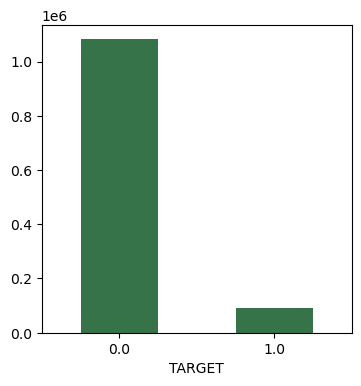

In [4]:
bureau.TARGET.value_counts().plot.bar(color='#377349', figsize=(4,4), rot=0);

### Observation:
- Most of the loans are paid back on time.
- The distribution of the target variable is right-skewed.
- Data is highly imbalanced that the proportion between class 0 and class 1 is about 92:8

# 4. Missing values

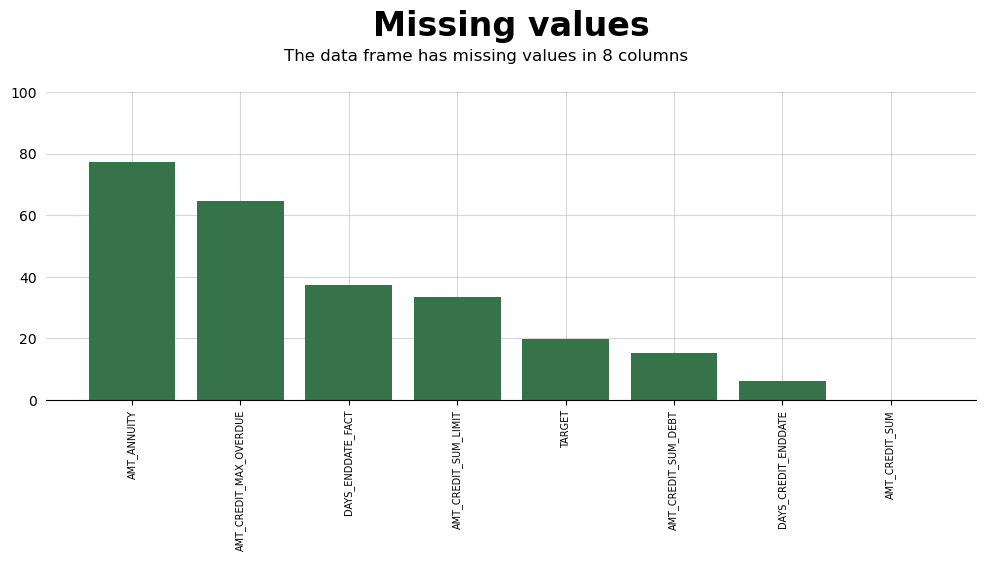

In [5]:
df_missing = create_df_missing(bureau)
plot_df_missing(df_missing, figsize=(12,4), x_title=0.5, x_subtitle=1.4)

### Observation:
- The column AMT_ANNUITY has the most significant number of missing values, suggesting that this feature may be less reliable for analysis without addressing these missing entries through methods such as imputation or exclusion.

- The columns AMT_CREDIT_MAX_OVERDUE, DAYS_ENDDATE_FACT, and AMT_CREDIT_SUM_LIMIT have a moderate number of missing values, indicating that any analysis involving these variables should consider the impact of data imputation or the possibility of biased interpretations due to missing information.

In [6]:
#Fill missing value
bureau['AMT_CREDIT_SUM'].fillna(bureau[['AMT_CREDIT_SUM']].mean(), inplace=True)
bureau['AMT_CREDIT_SUM_LIMIT'].fillna(0, inplace=True)

#AMT_CREDIT_SUM_DEBT talks about unpaid credit debt, so filling in 0 will not affect the loan decision.
bureau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)

#AMT_CREDIT_SUM_OVERDUE talks about late fees, so filling in 0 will not affect the loan decision.
bureau['AMT_CREDIT_MAX_OVERDUE'].fillna(0, inplace=True)

bureau['DAYS_CREDIT_ENDDATE'].fillna(0, inplace=True)
bureau['DAYS_CREDIT_UPDATE'].fillna(0, inplace=True)

#The NaN values in the DAYS_ENDDATE_FACT column represent an Active or Bad debt so we will not intervene.

bureau.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET
0,5714462,Closed,currency 1,-497,0,-153.00,-153.00,0.00,0,91323.00,0.00,0.00,0.00,Consumer credit,-131,NaN,254629,0.00
1,5714463,Active,currency 1,-208,0,1075.00,NaN,0.00,0,225000.00,171342.00,0.00,0.00,Credit card,-20,NaN,254629,0.00
2,5714464,Active,currency 1,-203,0,528.00,NaN,0.00,0,464323.50,0.00,0.00,0.00,Consumer credit,-16,NaN,254629,0.00
3,5714465,Active,currency 1,-203,0,0.00,NaN,0.00,0,90000.00,0.00,0.00,0.00,Credit card,-16,NaN,254629,0.00
4,5714466,Active,currency 1,-629,0,1197.00,NaN,77674.50,0,2700000.00,0.00,0.00,0.00,Consumer credit,-21,NaN,254629,0.00


# 5. Define Numerical and Categorical Features

In [7]:
bureau, cate_bureau, num_bureau = validate_dtype(bureau)

# 6. Imbalanced Class

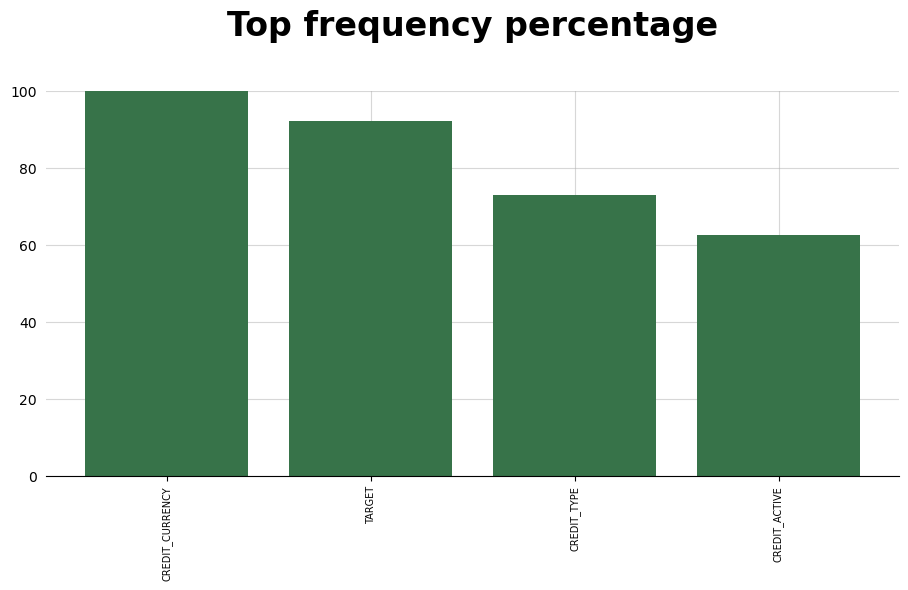

In [8]:
plot_imbalance(describe_class(cate_bureau), x_title=0.5, figsize=(11,5))

### Observation
- Some columns has high imbalanced class. For example, CREDIT_CURRENCY, TARGET can account for nearly 100% frequency.

In [9]:
bureau['CREDIT_CURRENCY'].value_counts()

CREDIT_CURRENCY
currency 1    1464094
currency 2       1072
currency 3        150
currency 4          9
Name: count, dtype: int64

### Observation:
Because the CREDIT_CURRENCY column has >99% currency 1, it is not useful when learning about a loan case => we will drop the CREDIT_CURRENCY column

In [10]:
bureau.drop(labels=["CREDIT_CURRENCY"],axis=1, inplace= True)

# 7. Outlier

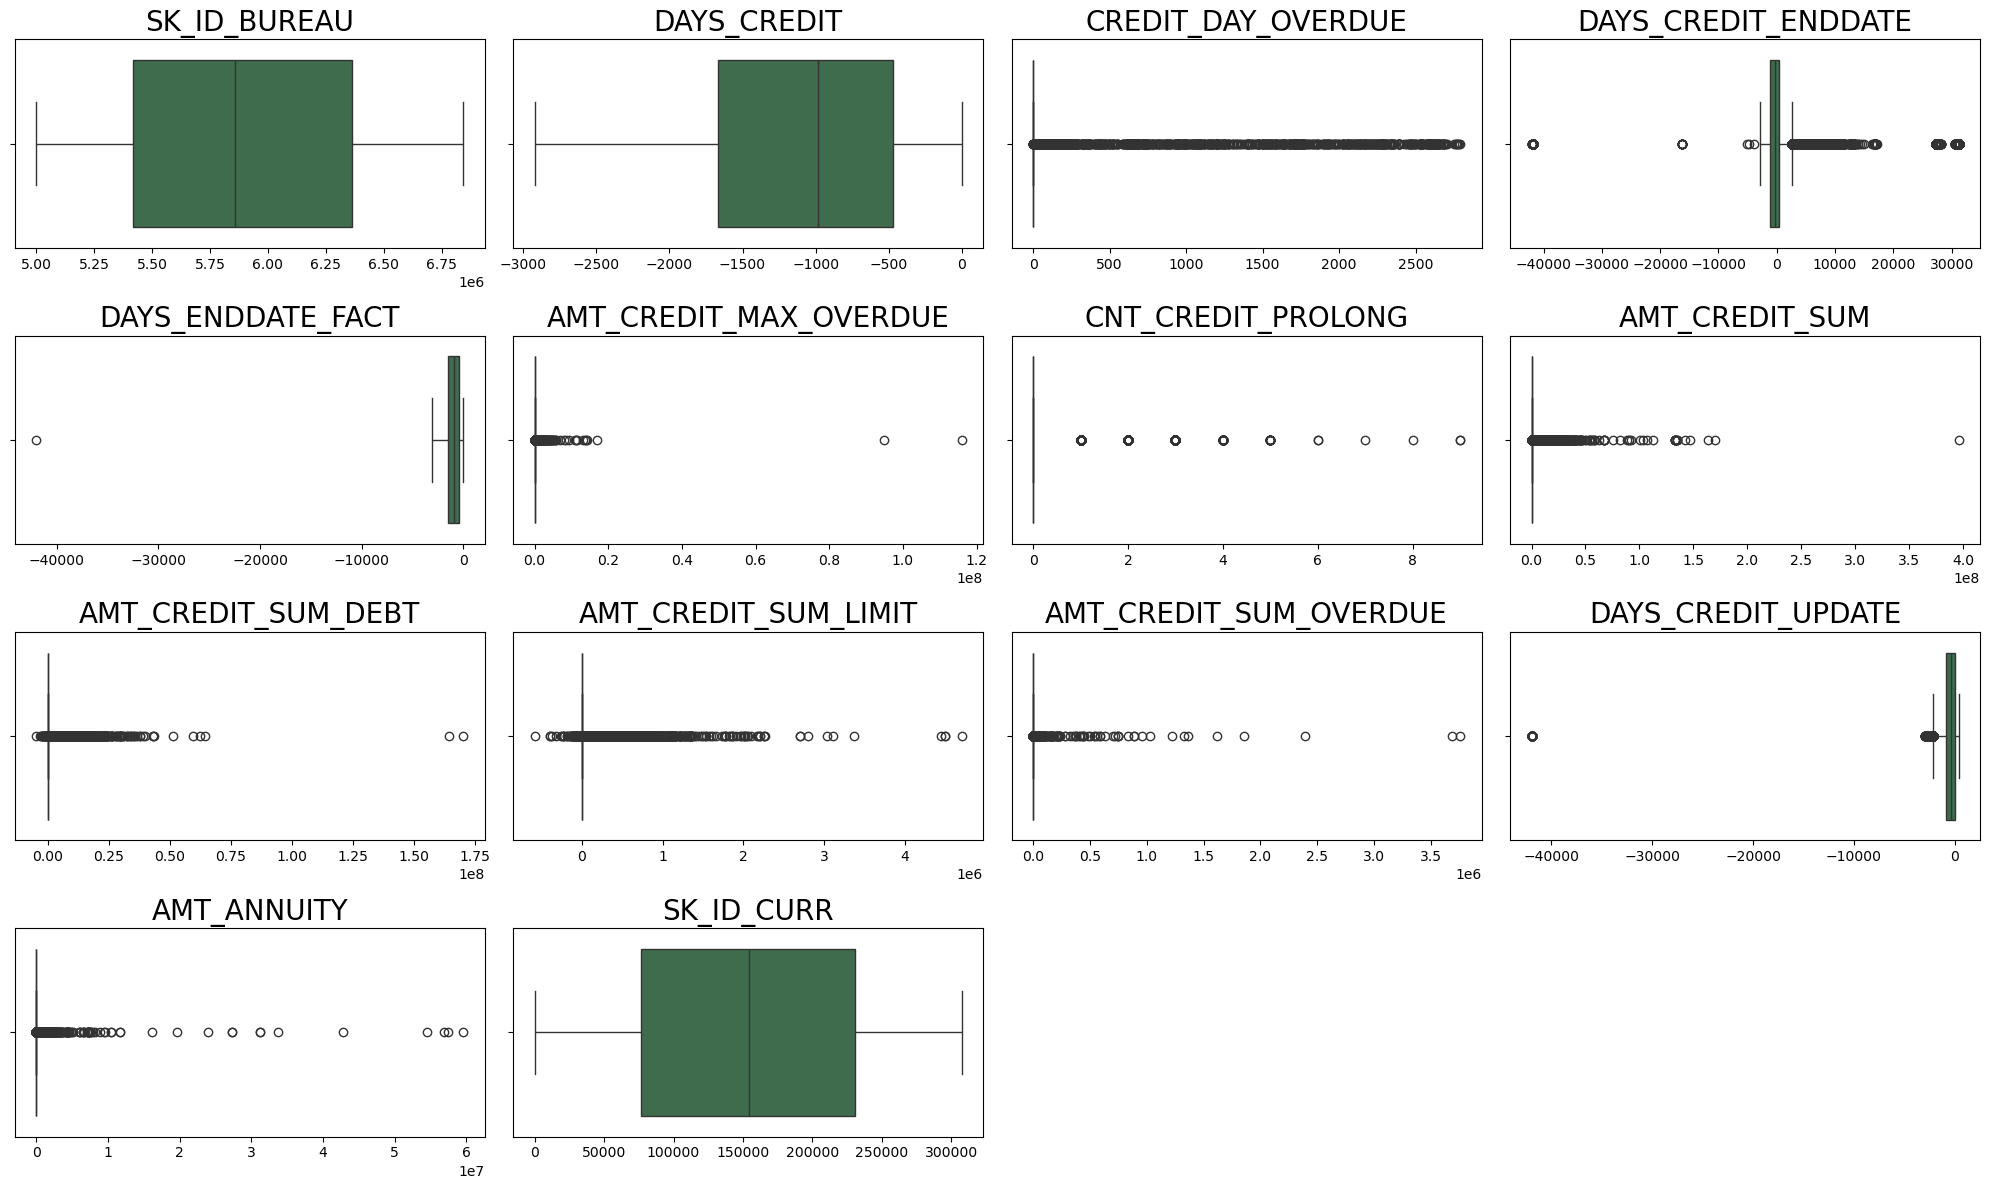

In [11]:
plot_boxplot(num_bureau, figsize=(20, 12))

### Observation:
- **Outliers:** Several variables, such as DAYS_CREDIT, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, and particularly AMT_CREDIT_MAX_OVERDUE, exhibit a significant number of outliers. These outliers could represent errors, unusual events, or simply variations within the population and may need to be investigated further or treated appropriately during analysis.

- **Variable Scales:** The variables displayed in the boxplots have a wide range of scales, from counts like CNT_CREDIT_PROLONG that are close to zero to amounts and days which span thousands. This suggests that normalization or scaling might be required before using these variables in machine learning models.

- **Data Distribution:** Some variables, such as AMT_CREDIT_SUM_DEBT and AMT_CREDIT_SUM_LIMIT, show a concentration of data near zero, indicating that many loans might not have any debt or set limit, or that for a large number of observations, these values are very low compared to the maximum values.

# 8. Anomalies

## 8.1 Numerical value

In [12]:
bureau.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,1465325.00,5890327.74,537827.07,5000000.00,5416944.00,5856021.00,6363543.00,6843457.00
DAYS_CREDIT,1465325.00,-1143.60,800.02,-2922.00,-1671.00,-985.00,-470.00,0.00
CREDIT_DAY_OVERDUE,1465325.00,0.89,38.25,0.00,0.00,0.00,0.00,2792.00
DAYS_CREDIT_ENDDATE,1465325.00,463.15,4813.04,-42060.00,-1079.00,-241.00,387.00,31199.00
DAYS_ENDDATE_FACT,920652.00,-1022.77,718.37,-42023.00,-1503.00,-900.00,-427.00,0.00
AMT_CREDIT_MAX_OVERDUE,1465325.00,1390.54,130476.57,0.00,0.00,0.00,0.00,115987185.00
CNT_CREDIT_PROLONG,1465325.00,0.01,0.10,0.00,0.00,0.00,0.00,9.00
AMT_CREDIT_SUM,1465322.00,351688.87,1078008.93,0.00,51165.00,124698.13,308250.00,396000000.00
AMT_CREDIT_SUM_DEBT,1465325.00,115200.09,624020.37,-4705600.32,0.00,0.00,598.14,170100000.00
AMT_CREDIT_SUM_LIMIT,1465325.00,4237.12,37198.88,-586406.11,0.00,0.00,0.00,4705600.32


**DAYS_CREDIT_ENDDATE (expected time to end the loan) observes values up to 31198 days ~ 84 years, which is unreasonable because normally long-term loans or installments only reach a term of 50 years (18,000 days). Moreover, there are some observations in DAYS_CREDIT_UPDATE with values up to 42000 days ~ 114 years. Such long time should affect the clarity of the analysis and the repay prediction. So here we will clean the values relating to days that are too large and set the limit to 50 years (18000 days)**

In [13]:
column_list = ['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']  

for column in column_list:
    bureau[column] = bureau[column].apply(lambda x: x if -50 * 365 < x < 50 * 365 else np.nan)

# 9. Correlation

In [14]:
cmat = CorrelationMatrix(bureau, drop_cols=['SK_ID_CURR', 'SK_ID_BUREAU'])

In [15]:
cmat.target_top()

,PhiK-Correlation
AMT_ANNUITY,0.42
AMT_CREDIT_SUM_DEBT,0.25
AMT_CREDIT_MAX_OVERDUE,0.16
AMT_CREDIT_SUM_LIMIT,0.14
DAYS_CREDIT,0.09
DAYS_CREDIT_ENDDATE,0.07
AMT_CREDIT_SUM,0.07
DAYS_CREDIT_UPDATE,0.07
CREDIT_ACTIVE,0.06
AMT_CREDIT_SUM_OVERDUE,0.06


## 9.1 Numerical Value

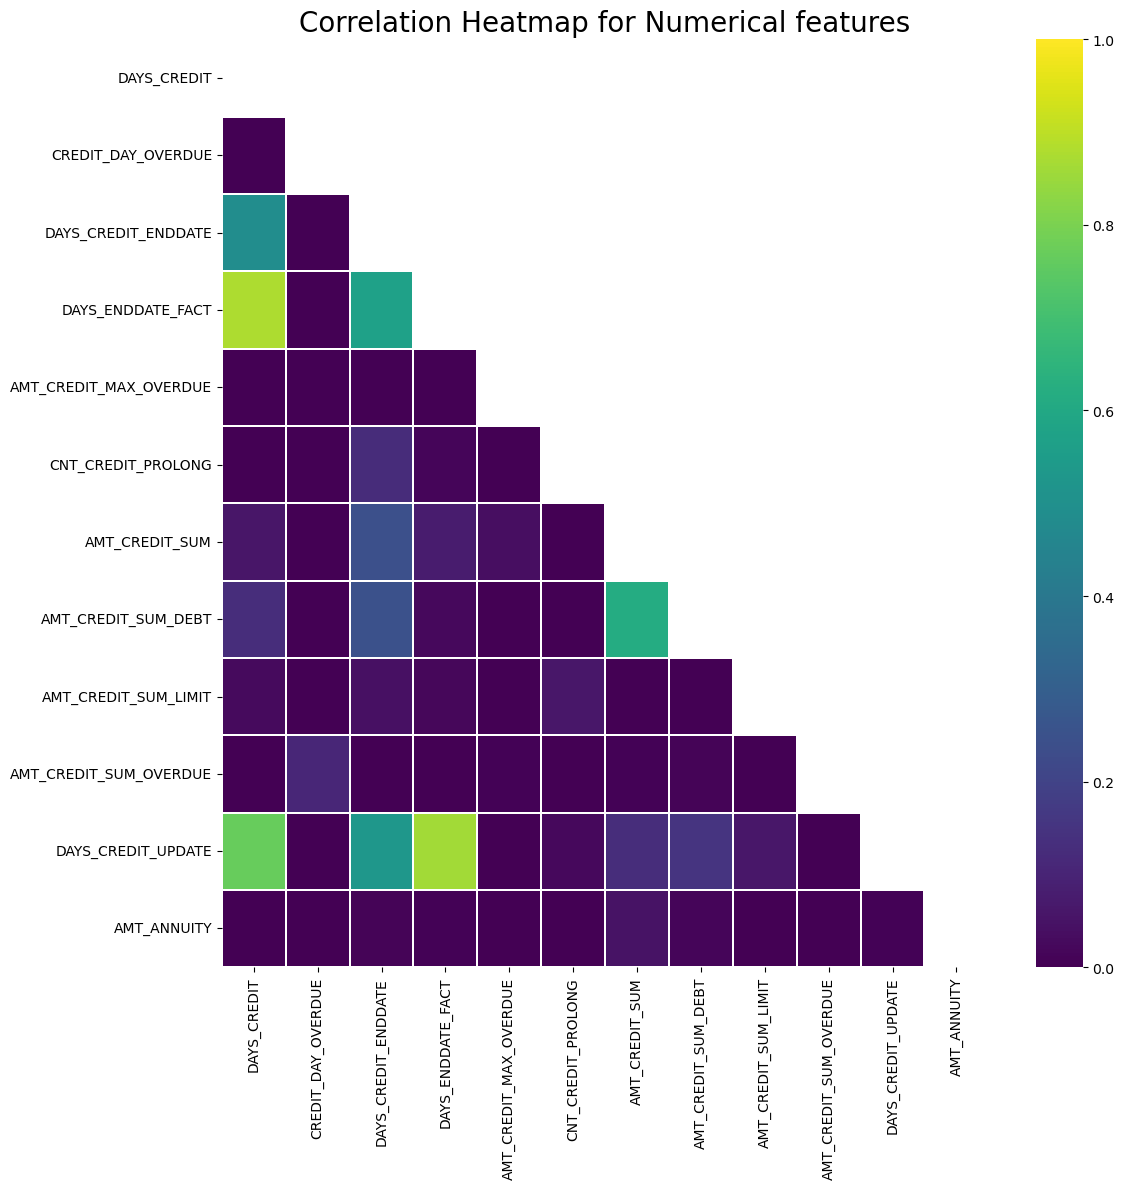

In [16]:
cmat.plot_correlation_matrix()

In [17]:
cmat.target_top_num()

,Correlation
DAYS_CREDIT,0.06
DAYS_CREDIT_UPDATE,0.05
DAYS_ENDDATE_FACT,0.04
DAYS_CREDIT_ENDDATE,0.02
AMT_CREDIT_SUM,0.01
AMT_CREDIT_SUM_OVERDUE,0.01
AMT_CREDIT_SUM_LIMIT,0.00
AMT_CREDIT_SUM_DEBT,0.00
CREDIT_DAY_OVERDUE,0.00
AMT_CREDIT_MAX_OVERDUE,0.00


### Observation:
- The heatmap shows some moderate correlations, particularly between some of the AMT_CREDIT related features (like AMT_CREDIT_SUM and AMT_CREDIT_SUM_DEBT).
- All the features have very weak correlations with the target, with the highest being DAYS_CREDIT at 0.05.
- This implies that none of these features strongly predict the target by themselves.

# 10. Categorical variables

## 10.1 CREDIT_ACTIVE 

Total Number of unique categories of CREDIT_ACTIVE = 4


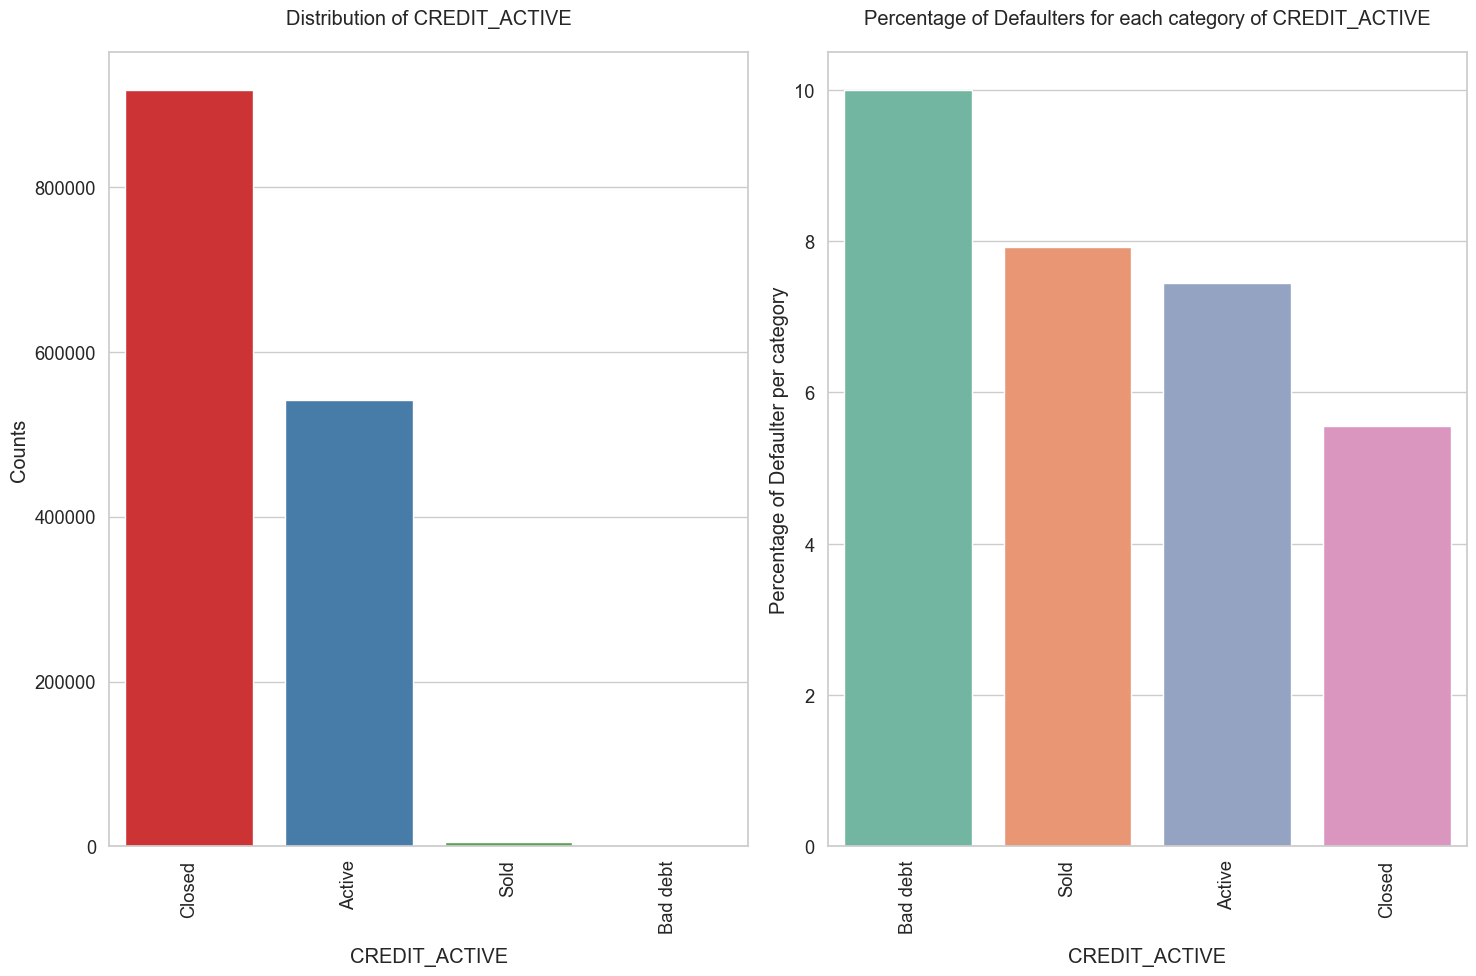

In [18]:
plot_categorical_variables_bar(bureau,'CREDIT_ACTIVE', figsize=(15,10))

### Observation:
- There are 4 types of credit active: Active, Closed, Sent proposal and Sold.
- Credit Status Distribution: A large majority of the credits are either closed or active, with closed credits making up over 60% of the total. Active credits account for approximately 37%, suggesting that most of the credits in the dataset have been settled or are currently being serviced.

- Default Rates by Credit Status: Credits categorized as 'Bad debt' have the highest default rate, which aligns with the conventional expectation that such debts are unlikely to be recovered. Credits that have been sold have a higher default rate than those that are active, which may indicate that sold debts are those that lenders consider at higher risk of default.

- Low Incidence Categories: The 'Bad debt' and 'Sold' categories have very low counts in the dataset, indicating these are less common credit statuses. However, these categories show disproportionately high default rates, likely due to the small sample size which could skew the percentage calculations.

## 10.2 CREDIT_TYPE

Total Number of unique categories of CREDIT_TYPE = 15


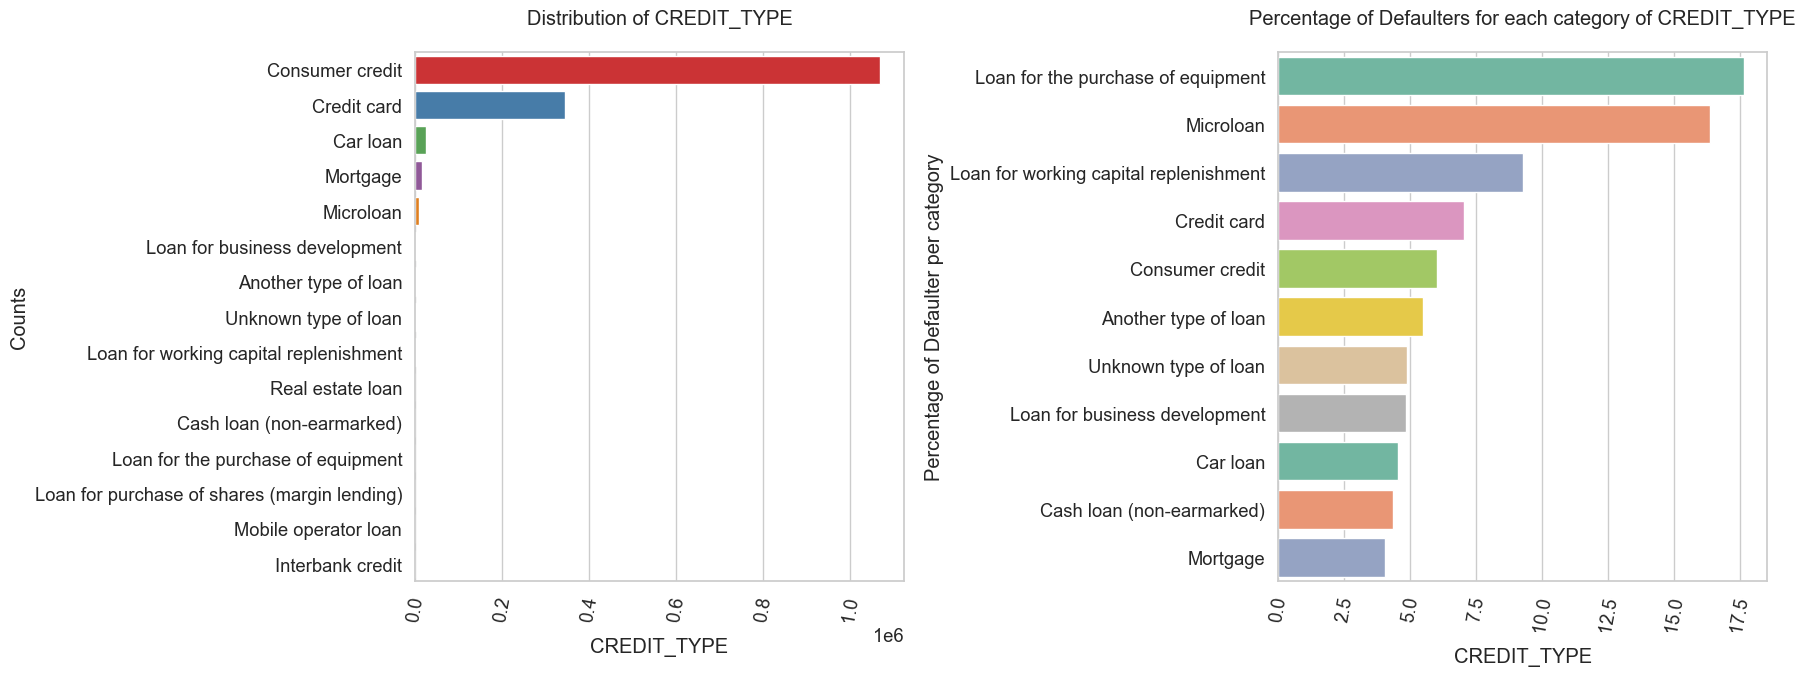

In [19]:
plot_categorical_variables_bar(bureau,'CREDIT_TYPE', figsize=(18,7),rotation=80, horizontal=0.25 )

### Observation:
- Credit Type Popularity: Consumer credit is the most common type of credit, suggesting that it is the most accessible or sought-after credit option for individuals within the dataset. Credit cards and car loans also show significant counts, indicating their popularity.

- Default Risk by Credit Type: The credit types associated with the purchase of equipment and microloans have the highest default rates. This could imply that these types of loans are riskier for lenders, possibly due to the nature of the investments they finance or the creditworthiness of the borrowers who typically use these loan types.

- Risk Distribution Disparity: There is a notable disparity between the popularity of credit types and their default rates. For instance, although consumer credit is very common, its default rate is not the highest, which might indicate effective risk management strategies in this credit category or a reliable borrower profile. Conversely, less common credit types like loans for equipment purchase exhibit higher default rates, which could reflect niche markets with higher inherent risks.

# 11. Numerical variables:

## 11.1.DAYS_CREDIT

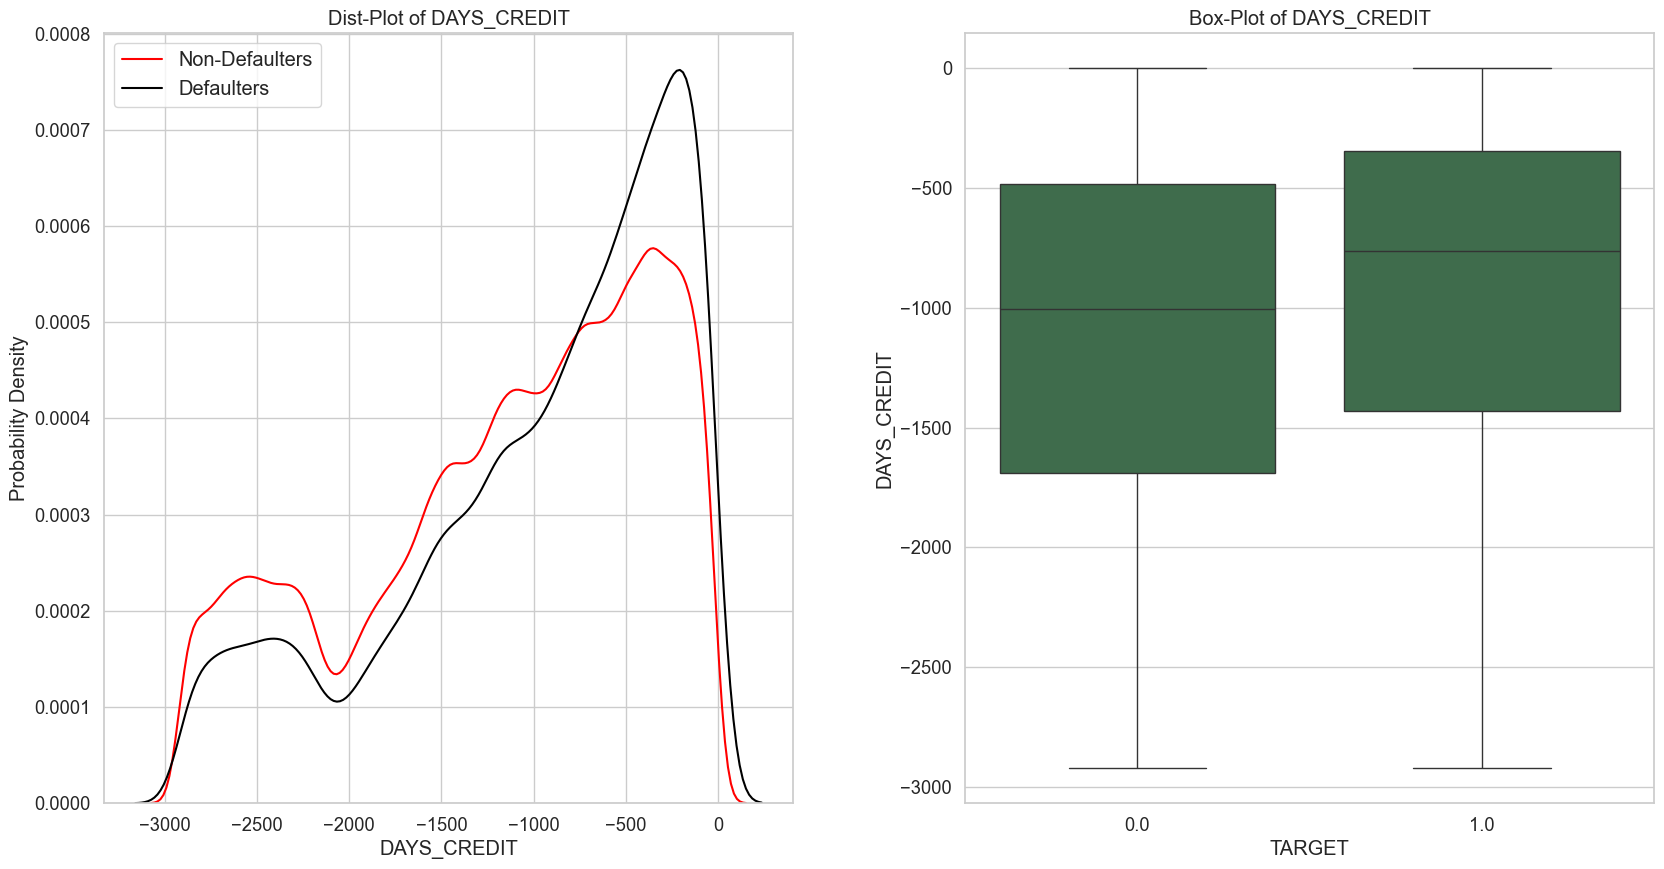

In [20]:
plot_continuous_variables(bureau,'DAYS_CREDIT', plots = ['distplot','box'],figsize=(20,10))

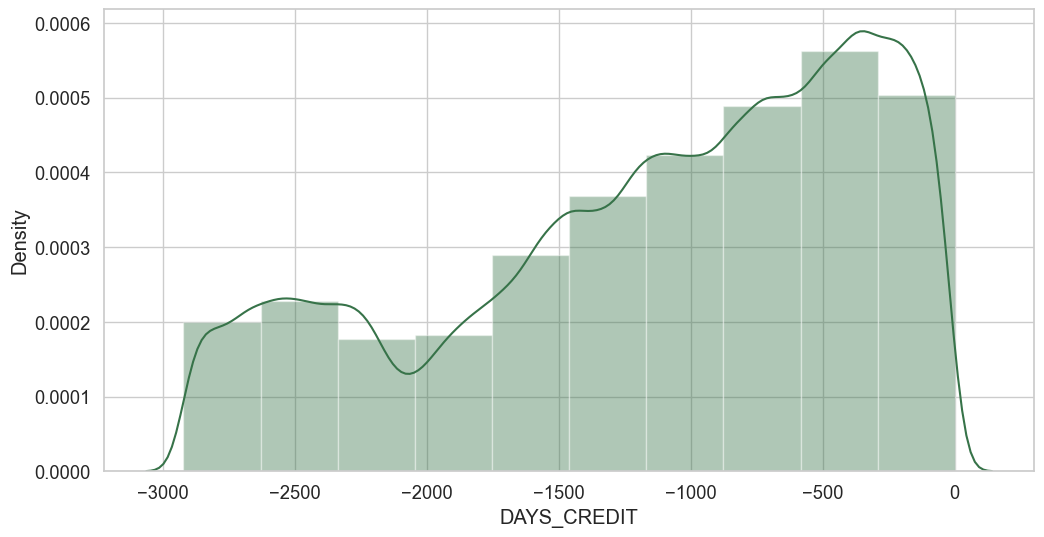

In [21]:
plt.figure(figsize= (12,6))
sns.distplot(bureau['DAYS_CREDIT'], bins=10, color='#377349')
plt.show()

### Observation:
- The density of defaulters (indicated by the red curve) appears to be slightly higher in certain areas, especially towards the right end of the axis (closer to 0 days), suggesting that those who are insolvent borrow more than those who are able to repay their debts.

## 11.2. CREDIT_DURATION

In [22]:
bureau['CREDIT_DURATION'] = np.abs(bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE'])

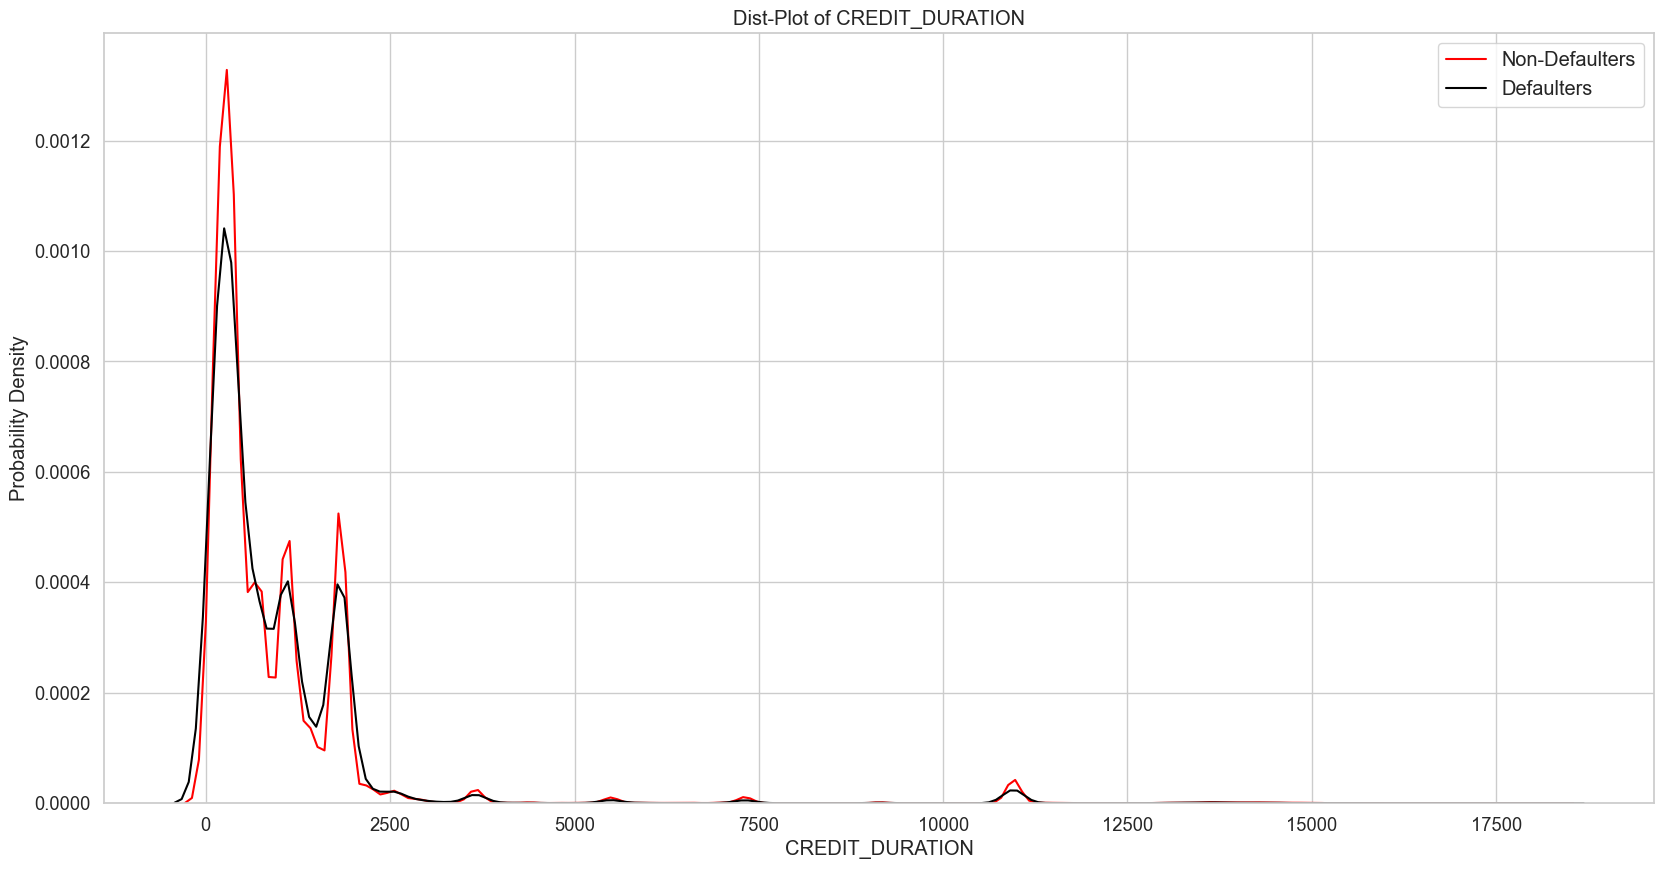

In [23]:
plot_continuous_variables(bureau,'CREDIT_DURATION', plots = ['distplot'],figsize=(20,10))

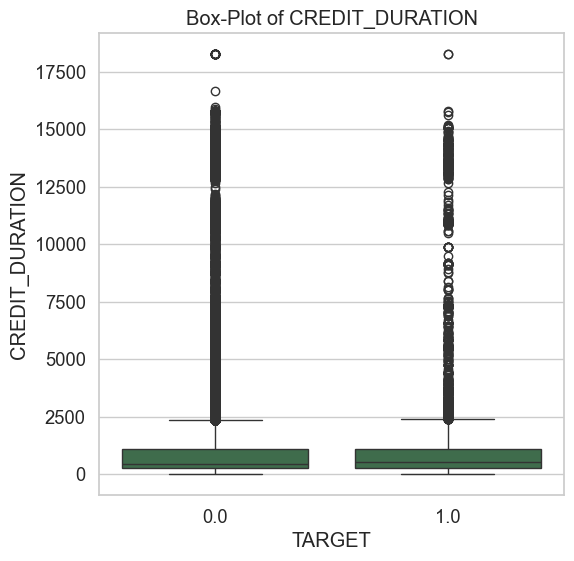

In [24]:
plot_continuous_variables(bureau,'CREDIT_DURATION', plots = ['box'], figsize=(6,6))

### Observation:
It can be seen that the percentage of loans with duration < 2500 days ~ 7 years accounts for the majority of total loans. That's why the number of defaulters is also higher than those with long-term loans. However, looking at the boxplot, the distribution between the two targets is quite even and this feature does not really create a difference to compare between the two categories. Besides, there exist many outliers.

## 11.3. ACTIVE_LOANS

In [25]:
bureau['ACTIVE_LOANS'] = bureau['CREDIT_ACTIVE'].apply(lambda status: 0 if status == 'Closed' else 1)

active_loans_by_customer = bureau.groupby(['SK_ID_CURR', 'TARGET'])['ACTIVE_LOANS'].mean().reset_index()
active_loans_by_customer.rename(columns={'ACTIVE_LOANS': 'ACTIVE_LOANS_PERCENTAGE'}, inplace=True)
active_loans_by_customer['ACTIVE_LOANS_PERCENTAGE'] *= 100
active_loans_by_customer

,SK_ID_CURR,TARGET,ACTIVE_LOANS_PERCENTAGE
0,0,0.00,100.00
1,1,1.00,100.00
2,2,0.00,33.33
3,3,0.00,42.86
4,4,0.00,50.00
...,...,...,...
210804,307501,0.00,20.00
210805,307504,0.00,25.00
210806,307505,0.00,100.00
210807,307506,0.00,0.00


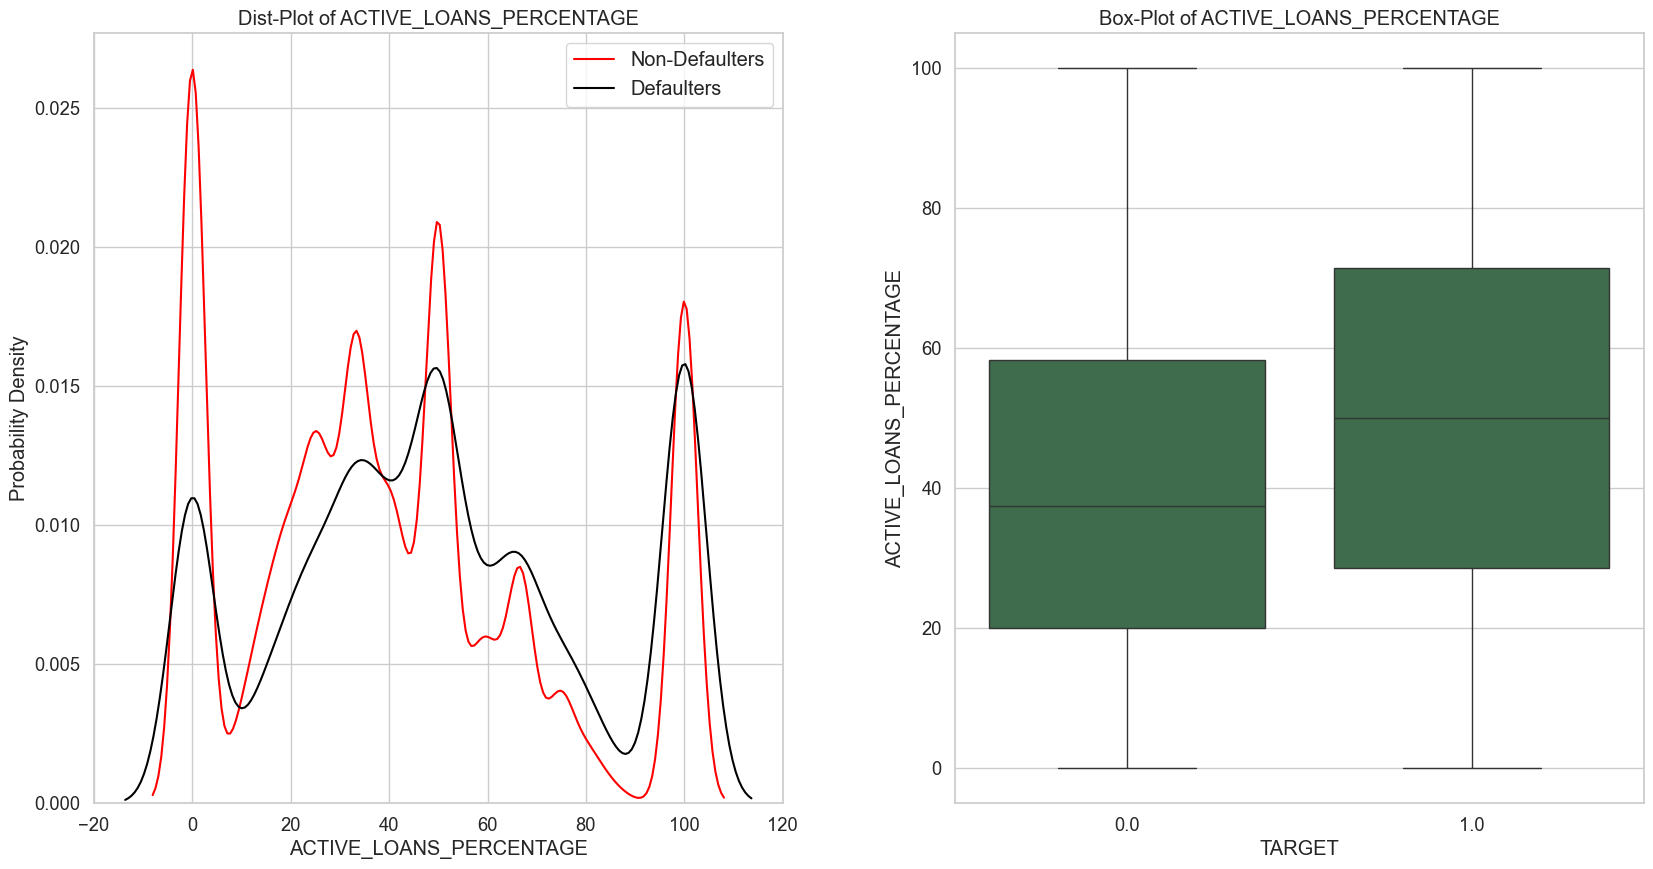

In [26]:
plot_continuous_variables(active_loans_by_customer,"ACTIVE_LOANS_PERCENTAGE", plots = ['distplot','box'],figsize=(20,10))

### Observation:
- The distribution for non-defaulters (red curve) shows slightly higher peaks, which may suggest that non-defaulters tend to have a higher proportion of active loans higher.
- Looking at the boxplot, the average active loans percentage (horizontal line inside the box) for defaulters appears to be slightly lower than for non-defaulters, which may imply suggests that, on average, defaulters have a lower proportion of active loans.
- The highest density for non-defaulters may suggest that having a higher proportion of active loans is more common among non-defaulters.
- The average ratio of active loans is slightly lower for defaulters, suggesting they may have a higher ratio of closed loans on average.
- The absence of outliers suggests that extreme values are uncommon for the percentage of active loans in both groups.

## 11.4. NUM_CREDIT_TYPES

In [27]:
num_credit_types = bureau[['SK_ID_CURR','CREDIT_TYPE','TARGET']].groupby(['SK_ID_CURR','TARGET']).nunique().reset_index()
num_credit_types.columns = ['SK_ID_CURR','TARGET','NUM_CREDIT_TYPES']
num_credit_types

,SK_ID_CURR,TARGET,NUM_CREDIT_TYPES
0,0,0.00,1
1,1,1.00,1
2,2,0.00,1
3,3,0.00,2
4,4,0.00,2
...,...,...,...
210804,307501,0.00,3
210805,307504,0.00,1
210806,307505,0.00,2
210807,307506,0.00,1


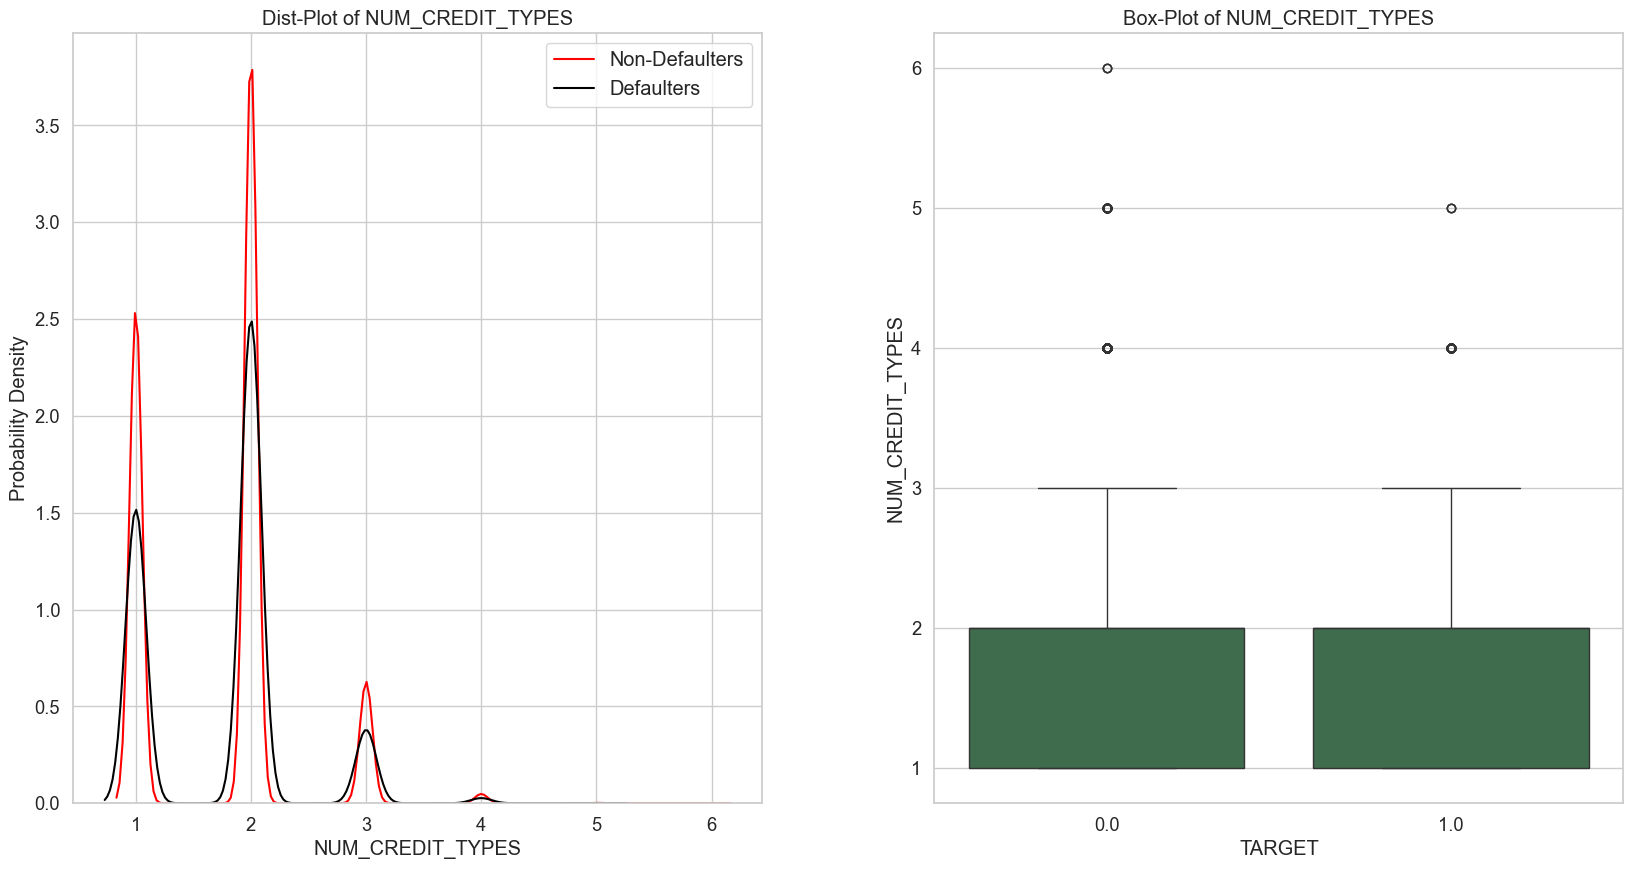

In [28]:
plot_continuous_variables(num_credit_types,'NUM_CREDIT_TYPES', plots = ['distplot','box'],figsize=(20,10))

### Observation:
- Most individuals borrow 1 or 2 types of credit, relatively few people have more than 3 types.
- There is no significant difference in the number of credit types when comparing defaulters with non-defaulters, based on density plots with similar relative distributions.

## 11.5. DEBT_CREDIT_RATIO

In [29]:
data_with_sum_debt_pos_sign = bureau[bureau['AMT_CREDIT_SUM_DEBT']>0]

# Only consider debt that has been completely repaid.
grp1 = data_with_sum_debt_pos_sign[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'TOTAL_CUSTOMER_CREDIT'})

bureau = bureau.merge(grp1, on = ['SK_ID_CURR'], how = 'left')
bureau = bureau.merge(grp2, on = ['SK_ID_CURR'], how = 'left')
del grp1, grp2


bureau['DEBT_CREDIT_RATIO'] = (bureau['TOTAL_CUSTOMER_DEBT']/bureau['TOTAL_CUSTOMER_CREDIT'])*100
bureau['DEBT_CREDIT_RATIO'] = bureau['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan)

del bureau['TOTAL_CUSTOMER_DEBT'], bureau['TOTAL_CUSTOMER_CREDIT']

debt_credit_target = bureau.groupby(by = ['SK_ID_CURR','TARGET'])['DEBT_CREDIT_RATIO'].mean().reset_index().rename(index=str)
debt_credit_target

,SK_ID_CURR,TARGET,DEBT_CREDIT_RATIO
0,0,0.00,90.71
1,1,1.00,NaN
2,2,0.00,37.91
3,3,0.00,41.07
4,4,0.00,44.45
...,...,...,...
210804,307501,0.00,74.14
210805,307504,0.00,13.83
210806,307505,0.00,NaN
210807,307506,0.00,NaN


In [30]:
debt_credit_target = debt_credit_target[debt_credit_target['DEBT_CREDIT_RATIO'] <= 100]

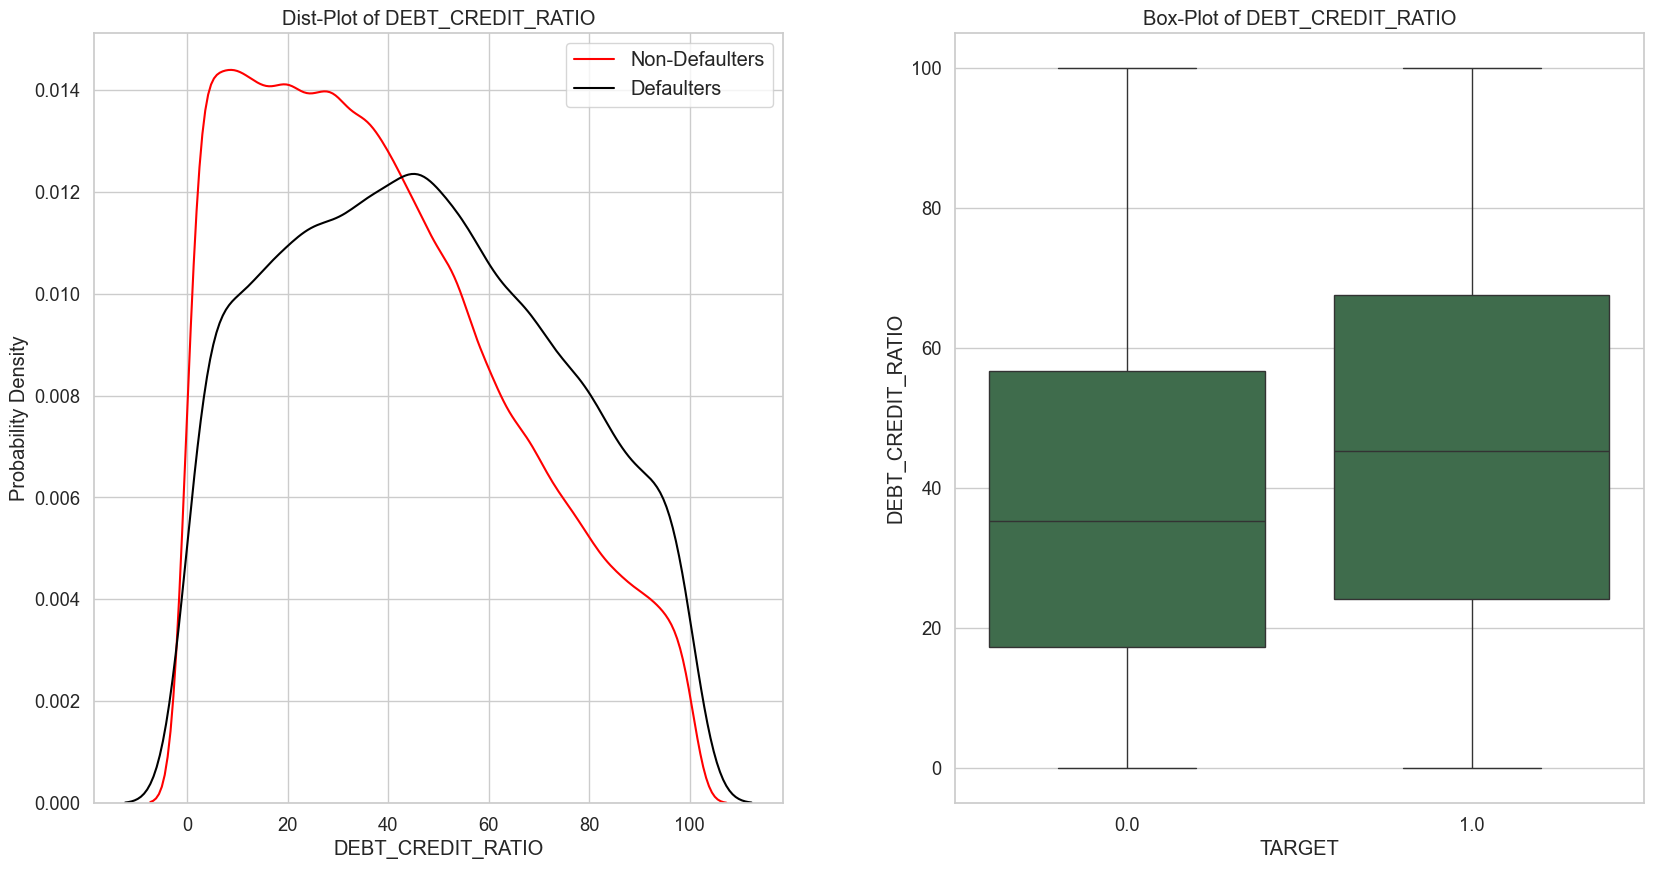

In [31]:
plot_continuous_variables(debt_credit_target,'DEBT_CREDIT_RATIO', plots = ['distplot','box'],figsize=(20,10))

### Observation:
- There is a peak near the bottom of this ratio for both groups, indicating that most customers have a lower debt-to-credit ratio.
- Non-defaulters (red curve) have a slightly higher peak than defaulters, indicating that a larger proportion of non-defaulters have lower debt-to-credit ratios.
- The average debt-to-credit ratio of non-defaulters (red box) is lower than that of defaulters (blue box), indicating that non-defaulters often have a good debt-to-credit ratio than.
- Customers who have defaulted (higher TARGET values) often have higher debt-to-credit ratios, suggesting that higher debt burdens may be associated with a higher probability of default.
- Non-defaulters tend to have lower and less variable debt-to-credit ratios.
- Both groups have a right-skewed distribution, but this skew is more pronounced for defaulters, reflecting that a significant number of them have very high levels of debt relative to their credit.